In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from torchsummary import summary
import os
import sys

if not os.path.exists('/content/efficient-kan'):
    !git clone https://github.com/Blealtan/efficient-kan

if '/content/efficient-kan/src' not in sys.path:
    sys.path.append('/content/efficient-kan/src')

from efficient_kan import KANLinear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path

Cloning into 'efficient-kan'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (15/15), done.
Receiving objects: 100% (84/84), 31.41 KiB | 2.09 MiB/s, done.
remote: Total 84 (delta 19), reused 14 (delta 13), pack-reused 56
Resolving deltas: 100% (31/31), done.


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/efficient-kan/src']

### Download dataset

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1pkGt0mFH9ydwDIs1WyVAGM5dbmNpY34W

Downloading...
From: https://drive.google.com/uc?id=1pkGt0mFH9ydwDIs1WyVAGM5dbmNpY34W
To: /content/wine+quality.zip
100% 91.4k/91.4k [00:00<00:00, 89.0MB/s]


In [ ]:
!unzip wine+quality.zip

Archive:  wine+quality.zip
  inflating: winequality-red.csv     
  inflating: winequality-white.csv   
  inflating: winequality.names       


In [ ]:
!rm wine+quality.zip winequality.names

### Preprocessing



In [ ]:
red_df = pd.read_csv('winequality-red.csv', sep=';')
white_df = pd.read_csv('winequality-white.csv', sep=';')

red_df['type'] = 'red'
white_df['type'] = 'white'

df = pd.concat([red_df, white_df])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [ ]:
categorical_columns = ['type']
numerical_columns = [col for col in df.columns if col not in categorical_columns]

encoder = OneHotEncoder()
categorical_one_hot = encoder.fit_transform(df[categorical_columns])
categorical_one_hot = pd.DataFrame(categorical_one_hot.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

df.reset_index(drop=True, inplace=True)
df_preprocessed = pd.concat([df[numerical_columns], categorical_one_hot], axis=1)
df_preprocessed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.0,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0,0.0


In [ ]:
X = df_preprocessed.drop('quality', axis=1).to_numpy()
y = df_preprocessed['quality'].to_numpy()

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X = (X - X_mean) / X_std

In [ ]:
print(X[0], X.shape)
print(y[0], y.shape)

for i in range(11):
    print(f'{i} quality has {np.sum(y == i)} sample')

[ 0.14247327  2.18883292 -2.19283252 -0.7447781   0.56995782 -1.10013986
 -1.44635852  1.03499282  1.81308951  0.19309677 -0.91546416  1.75018984
 -1.75018984] (6497, 13)
5 (6497,)
0 quality has 0 sample
1 quality has 0 sample
2 quality has 0 sample
3 quality has 30 sample
4 quality has 216 sample
5 quality has 2138 sample
6 quality has 2836 sample
7 quality has 1079 sample
8 quality has 193 sample
9 quality has 5 sample
10 quality has 0 sample


### Dataloader

In [ ]:
split_point = int(0.8 * len(X))
X_train, y_train = X[:split_point], y[:split_point]
X_val, y_val = X[split_point:], y[split_point:]

print(X_train.shape, X_val.shape)

(5197, 13) (1300, 13)


In [ ]:
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = WineDataset(X_train, y_train)
val_dataset = WineDataset(X_val, y_val)

batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Model

In [ ]:
class SinLU(nn.Module):
    def __init__(self):
        super(SinLU, self).__init__()
        self.a = nn.Parameter(torch.ones(1))
        self.b = nn.Parameter(torch.ones(1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(x) * (x + self.a * torch.sin(self.b * x))

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x * 10

In [ ]:
class GLU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation

        self.fc_gate = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()

        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x1 = self.fc1(x)
        x1 = self.activation(x1)

        x_gate = self.fc_gate(x)
        x_gate = self.sigmoid(x_gate)

        x2 = self.fc2(x1 * x_gate)
        x2 = self.sigmoid(x2)
        return x2 * 10

In [ ]:
class KAN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(KAN, self).__init__()
        self.fc1 = KANLinear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x * 10

In [ ]:
MLP_model = MLP(input_dim=13, hidden_dim=256, output_dim=1, activation=SinLU())
MLP_model.to(device)

MLP_optimizer = optim.AdamW(MLP_model.parameters(), lr=0.01, weight_decay=0.01)
MLP_criterion = nn.MSELoss()

In [ ]:
GLU_model = GLU(input_dim=13, hidden_dim=256, output_dim=1, activation=SinLU())
GLU_model.to(device)

GLU_optimizer = optim.AdamW(GLU_model.parameters(), lr=0.01, weight_decay=0.01)
GLU_criterion = nn.MSELoss()

In [ ]:
KAN_model = KAN(13, 1)
KAN_model.to(device)

KAN_optimizer = optim.AdamW(KAN_model.parameters(), lr=0.01, weight_decay=0.01)
KAN_criterion = nn.MSELoss()

### Train

In [ ]:
def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=10):
    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)

        model.eval()
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            test_loss += loss.item()

        test_loss /= len(test_loader)
        test_loss_list.append(test_loss)

        print(f'Epoch {epoch + 1}, Train loss: {train_loss}, Test loss: {test_loss}')

    return train_loss_list, test_loss_list

num_epochs = 100

In [ ]:
MLP_train_loss_list, MLP_test_loss_list = train_model(MLP_model, MLP_optimizer, MLP_criterion, train_dataloader, val_dataloader, num_epochs=num_epochs)

Epoch 1, Train loss: 18.400966916765487, Test loss: 17.716745376586914
Epoch 2, Train loss: 18.395757130214147, Test loss: 17.716715494791668
Epoch 3, Train loss: 18.358111245291575, Test loss: 17.716678301493328
Epoch 4, Train loss: 18.439363479614258, Test loss: 17.71662934621175
Epoch 5, Train loss: 18.384832018897647, Test loss: 17.716561953226726
Epoch 6, Train loss: 18.416323253086635, Test loss: 17.716464360555012
Epoch 7, Train loss: 18.404980069115048, Test loss: 17.71631685892741
Epoch 8, Train loss: 18.419949849446613, Test loss: 17.716063499450684
Epoch 9, Train loss: 18.407969156901043, Test loss: 17.715474764506023
Epoch 10, Train loss: 18.40420405069987, Test loss: 17.713401794433594
Epoch 11, Train loss: 18.353633789789107, Test loss: 17.54644775390625
Epoch 12, Train loss: 10.1164162840162, Test loss: 6.958163181940715
Epoch 13, Train loss: 4.881388266881307, Test loss: 0.816393127044042
Epoch 14, Train loss: 0.9709857390040443, Test loss: 0.6728545327981313
Epoch 15, 

In [ ]:
GLU_train_loss_list, GLU_test_loss_list = train_model(GLU_model, GLU_optimizer, GLU_criterion, train_dataloader, val_dataloader, num_epochs=num_epochs)

Epoch 1, Train loss: 18.412135169619607, Test loss: 17.71668243408203
Epoch 2, Train loss: 18.36800221034459, Test loss: 17.716644287109375
Epoch 3, Train loss: 18.398653121221635, Test loss: 17.716593742370605
Epoch 4, Train loss: 18.378715333484468, Test loss: 17.716524759928387
Epoch 5, Train loss: 18.390313466389973, Test loss: 17.716434160868328
Epoch 6, Train loss: 18.370328630719865, Test loss: 17.716302235921223
Epoch 7, Train loss: 18.420783542451403, Test loss: 17.716105461120605
Epoch 8, Train loss: 18.39761797587077, Test loss: 17.71577517191569
Epoch 9, Train loss: 18.365285055977957, Test loss: 17.715171813964844
Epoch 10, Train loss: 18.437136059715634, Test loss: 17.71368630727132
Epoch 11, Train loss: 18.411027272542317, Test loss: 17.70750681559245
Epoch 12, Train loss: 18.325510660807293, Test loss: 15.054522355397543
Epoch 13, Train loss: 6.986747770082383, Test loss: 0.7616793016592661
Epoch 14, Train loss: 1.393365087963286, Test loss: 0.6699374814828237
Epoch 15,

In [ ]:
KAN_train_loss_list, KAN_test_loss_list = train_model(KAN_model, KAN_optimizer, KAN_criterion, train_dataloader, val_dataloader, num_epochs=num_epochs)

Epoch 1, Train loss: 16.232921872820175, Test loss: 15.169001897176107
Epoch 2, Train loss: 15.302471206301735, Test loss: 12.12473996480306
Epoch 3, Train loss: 10.697195189339775, Test loss: 5.013863364855449
Epoch 4, Train loss: 4.142744263013204, Test loss: 1.3139105041821797
Epoch 5, Train loss: 1.3482446670532227, Test loss: 0.8177345196406046
Epoch 6, Train loss: 0.9672531996454511, Test loss: 0.7870602905750275
Epoch 7, Train loss: 0.8820153758639381, Test loss: 0.727933386961619
Epoch 8, Train loss: 0.8579379887807936, Test loss: 0.7009101907412211
Epoch 9, Train loss: 0.8335389267830622, Test loss: 0.6851496249437332
Epoch 10, Train loss: 0.8263365228970846, Test loss: 0.6673979759216309
Epoch 11, Train loss: 0.8069467459406171, Test loss: 0.6594997843106588
Epoch 12, Train loss: 0.8015510894003368, Test loss: 0.6513467033704122
Epoch 13, Train loss: 0.7980212427320934, Test loss: 0.64626245200634
Epoch 14, Train loss: 0.8003582869257245, Test loss: 0.6426868587732315
Epoch 1

### Visualization

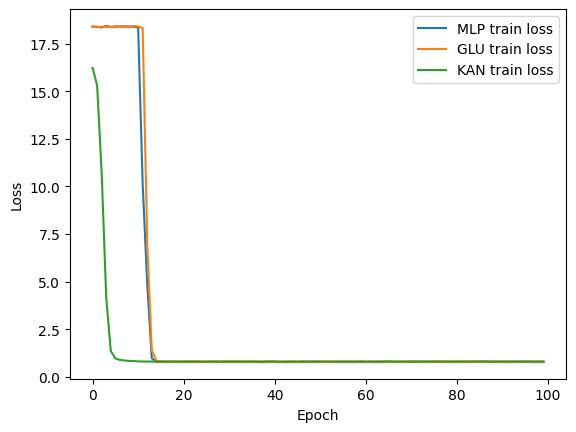

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MLP_train_loss_list, label='MLP train loss')
plt.plot(GLU_train_loss_list, label='GLU train loss')
plt.plot(KAN_train_loss_list, label='KAN train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

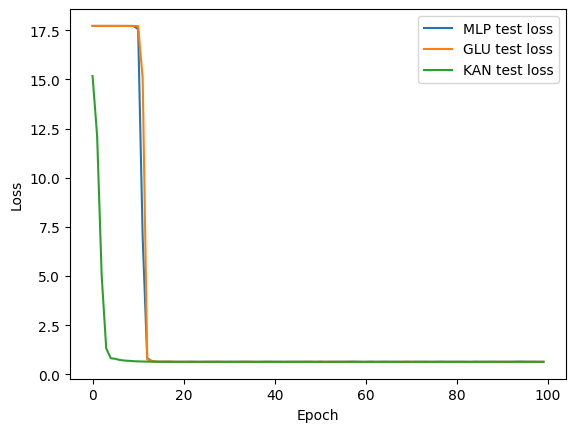

In [ ]:
plt.plot(MLP_test_loss_list, label='MLP test loss')
plt.plot(GLU_test_loss_list, label='GLU test loss')
plt.plot(KAN_test_loss_list, label='KAN test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()